In [22]:
from ppget.source import ModelSource
import matplotlib as mplt
mplt.rcParams["figure.figsize"] = (20,5)

start_date = "2007-07-01"
end_date = "2007-07-08"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: H, Name: Global_active_power, dtype: float64)

In [23]:
series = source.series()
series.head()

timestamp
2007-07-01 00:00:00    2.493733
2007-07-01 01:00:00    0.990900
2007-07-01 02:00:00    0.789900
2007-07-01 03:00:00    0.287467
2007-07-01 04:00:00    0.515533
Freq: H, Name: Global_active_power, dtype: float64

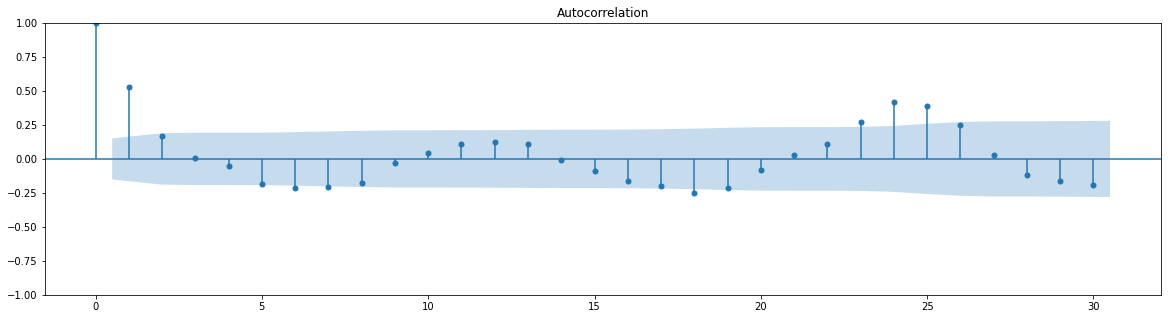

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(series, lags=30)

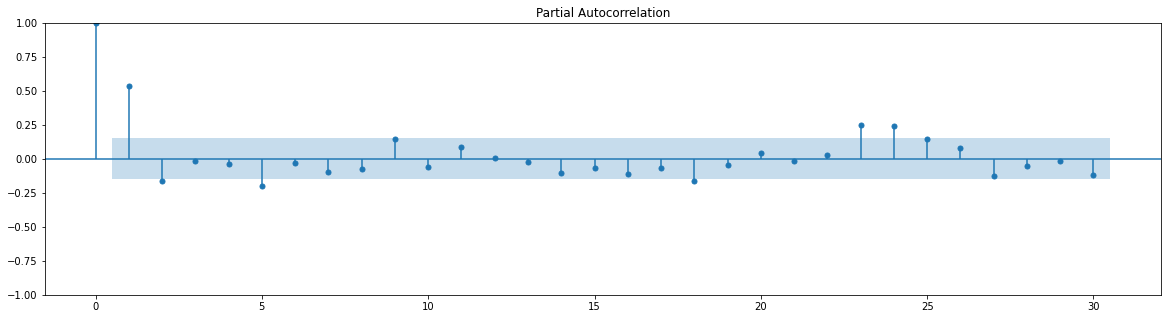

In [25]:
pacf = plot_pacf(series, lags=30)

In [26]:
import pandas as pd

values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
dataframe.head(5)

,t,t+1
0,NaN,2.493733
1,2.493733,0.990900
2,0.990900,0.789900
3,0.789900,0.287467
4,0.287467,0.515533


In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = dataframe.values
train_size = int(len(X) * 0.7)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_baseline(x):
  return x

def RMSE(expected, predicted):
    return sqrt(mean_squared_error(expected, predicted))

def validate_model(model, cost, expected, validation):
    p = [model(x) for x in validation]
    return cost(expected, p), p

In [28]:
import warnings
from math import sqrt
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.7)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	model = ARIMA(history, order=arima_order)
	model_fit = model.fit()
	predictions = model_fit.forecast()
	rmse = RMSE([test[0]], predictions)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for order in itertools.product(p_values, d_values, q_values):
        rmse = evaluate_arima_model(dataset, order)
        if rmse < best_score:
            best_score, best_cfg = rmse, order
    print(f"Best ARIMA{best_cfg} RMSE={best_score}")
    return best_cfg

# evaluate parameters
p_values = [0,1,2]
d_values = [0,1,2]
q_values = [0,1,2]

In [29]:
%%time
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(2, 0, 1) RMSE=0.17948428952692508
CPU times: user 4.74 s, sys: 717 ms, total: 5.45 s
Wall time: 1.96 s


In [30]:
%%time

history = [x for x in train_X]

def arima_model(x):
    best_fit = ARIMA(history, order=best_cfg).fit()
    history.append(x)
    return best_fit.forecast()[0]

error, predictions = validate_model(model=arima_model,
                                    cost=RMSE,
                                    expected=test_y,
                                    validation=test_X)

print(f"ARIMA RMSE: {error}")

ARIMA RMSE: 0.9073866674227618
CPU times: user 13.8 s, sys: 1.68 s, total: 15.4 s
Wall time: 7.9 s


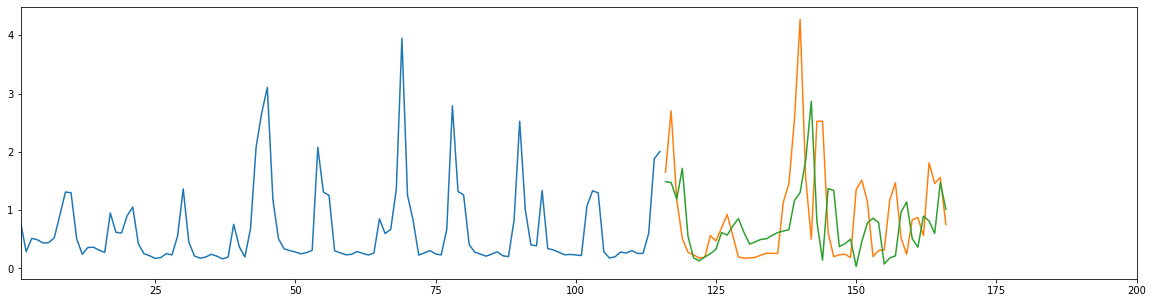

In [34]:
import matplotlib.pyplot as plt

plt.xlim([1, 200])
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()